## Imports

In [49]:
import torch
from torch import nn, optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt

## Data

In [50]:
transform = transforms.ToTensor()

In [51]:
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

In [52]:
train_loader = DataLoader(dataset=train_data, batch_size=20, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=20, shuffle=True)

## Model

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [54]:
class FMNISTConvAutoEncoder(nn.Module):

    def __init__(self):

        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        self.max_1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.conv_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1)
        self.max_2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.bottle_neck = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=1, padding=1)

        self.conv_3 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=1, padding=1)
        self.up_sample_1 = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv_4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        self.up_sample_2 = nn.Upsample(scale_factor=2, mode='nearest')

        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(3, 3), stride=1, padding=1)


    def forward(self, x):
        x = torch.relu(self.conv_1(x))
        x = self.max_1(x)

        x = torch.relu(self.conv_2(x))
        x = self.max_2(x)

        x = self.bottle_neck(x)

        x = torch.relu(self.conv_3(x))
        x = self.up_sample_1(x)

        x = torch.relu(self.conv_4(x))
        x = self.up_sample_2(x)

        x = torch.sigmoid(self.out(x))

        return x

In [55]:
model = FMNISTConvAutoEncoder().to(device)
model

FMNISTConvAutoEncoder(
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottle_neck): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up_sample_1): Upsample(scale_factor=2.0, mode=nearest)
  (conv_4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up_sample_2): Upsample(scale_factor=2.0, mode=nearest)
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## Train

In [56]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
EPOCHS = 30

In [57]:
for epoch in range(EPOCHS):

    train_loss = 0

    for images, labels in train_loader:

        images = images.to(device)

        preds = model(images)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            loss = criterion(preds, images)
            loss.backward()
            optimizer.step()

        train_loss += loss

    print(f'Epoch{epoch}: loss={train_loss}')


Epoch0: loss=17.25185203552246
Epoch1: loss=7.005546569824219
Epoch2: loss=5.413476467132568
Epoch3: loss=4.623769760131836
Epoch4: loss=4.18428897857666
Epoch5: loss=3.8661036491394043
Epoch6: loss=3.642118215560913
Epoch7: loss=3.4574809074401855
Epoch8: loss=3.3030176162719727
Epoch9: loss=3.195756673812866
Epoch10: loss=3.100921869277954
Epoch11: loss=3.0451574325561523
Epoch12: loss=2.967836618423462
Epoch13: loss=2.9232842922210693
Epoch14: loss=2.862997531890869
Epoch15: loss=2.8352530002593994
Epoch16: loss=2.7885191440582275
Epoch17: loss=2.7641942501068115
Epoch18: loss=2.7236058712005615
Epoch19: loss=2.6930506229400635
Epoch20: loss=2.683253049850464
Epoch21: loss=2.6347451210021973
Epoch22: loss=2.6261703968048096
Epoch23: loss=2.598139524459839
Epoch24: loss=2.5799973011016846
Epoch25: loss=2.5576305389404297
Epoch26: loss=2.5349225997924805
Epoch27: loss=2.5253946781158447
Epoch28: loss=2.502387523651123
Epoch29: loss=2.493622064590454


## Results

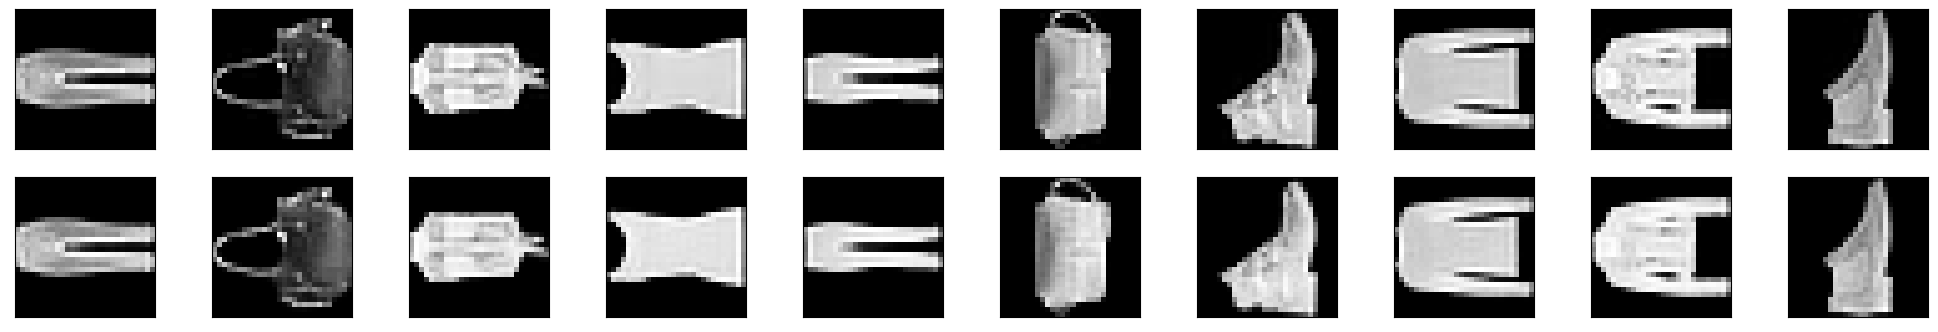

In [62]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

output = model(images)

images = images.permute(0, 3, 1, 2)
images = images.detach().cpu().numpy()

output = output.permute(0, 3, 1, 2)
output = output.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)